In [384]:
import numpy as np
import itertools
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

In [385]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])


    return faces

** Get the Camera Intrinsic Matrix**

In [386]:
def get_camera_intrinsics(alpha=70, beta=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    alpha (float): focal length in x-direction f_x
    beta (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''
    K = np.array([[alpha, 0, cx],
                  [0, beta, cy],
                  [0, 0, 1]],dtype=np.float32)
    return K


** Get the Perspective Projection Matrix**

In [387]:
def get_perspective_projection(x_c, K):
    ''' Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.
    
    Args:
        x_c (array): 3D points in camera space (nx3), n is the num of points
        K (array): camera intrinsics matrix (3x3)
    '''
    # transform x_c to homogeneous coordinates (nx4)
    projected_point = np.dot(K, x_c.T).T
    # normalize the projected points (nx3)
    x = projected_point[:, 0] / projected_point[:, 2]
    y = projected_point[:, 1] / projected_point[:, 2]
    x_s = np.array([x, y],dtype=np.float32)
    
    return x_s

** get the project cube**

In [388]:
def project_cube(cube, K):
    ''' Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    
    projected_cube =[]
    # interate through each face of the cube
    for face in cube:
        projected_cube.append(np.array(get_perspective_projection(face,K),dtype=np.float32))
    
    return np.array(projected_cube,dtype=np.float32)

In [389]:
from scipy.spatial import ConvexHull


def plot_projected_cube(projected_cube):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Collect all the points from the projected cube
    points = []
    for face in projected_cube:
        for i in range(face.shape[1]):
            points.append((face[0][i], face[1][i]))
   
    # Remove duplicate points
    unique_points = frozenset(map(tuple, points))
    points = np.array(list(unique_points))
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], label='Projected Corner Points')

    # Compute the convex hull of the points
    hull = ConvexHull(points)
    convex_points = points[hull.vertices]
    # Plot the convex hull
    ax.fill(convex_points[:, 0], convex_points[:, 1], 'gray', alpha=0.5, label='Filled Convex Hull')

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.ylim(0,120)
    plt.xlim(0,120)
    plt.show()

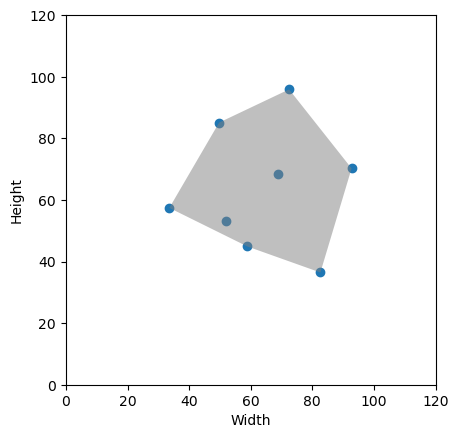

In [390]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)